In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import cv2
import mediapipe as mp
import ast

In [ ]:
def count_subdirs_and_images(root_dir):
    total_subdirs = 0
    total_images = 0

    # Iterate over all subdirectories with in the roor directory.
    for subdir, dirs, _ in os.walk(root_dir):
        for d in dirs:
            # Increment the subdirectory count.
            total_subdirs += 1

            # Count the number of images in the subdirectory.
            image_count = len(glob.glob(os.path.join(subdir, d, '*.*')))
            total_images += image_count
            print(f"Subdirectory: {os.path.join(subdir, d)}, Images: {image_count}")

    return total_subdirs, total_images


total_subdirs, total_images = count_subdirs_and_images("../dataset")
print(f"Total subdirectories: {total_subdirs}")
print(f"Total images: {total_images}")

In [ ]:
# Initialize the MediaPipe pose.
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=True)

# Load Image.
image_path = '/Users/jyothivishnuvardhankolla/Desktop/Yoga_pose_estimation/dataset/adho mukha svanasana/1. 5-benefits-of-downward-facing-dog-pose.png'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform pose estimation.
result = pose.process(image_rgb)

# Draw keypoints and connections on the image
annotated_image = image.copy()
mp_drawing.draw_landmarks(annotated_image, result.pose_landmarks, mp_pose.POSE_CONNECTIONS)

# Save the annotated image
cv2.imwrite('annotated_image.jpg', annotated_image)

# Print keypoints
if result.pose_landmarks:
    for idx, landmark in enumerate(result.pose_landmarks.landmark):
        print(f"Keypoint {idx}: ({landmark.x}, {landmark.y}, {landmark.z})")

# Release resources
pose.close()


In [ ]:
df = pd.read_csv("../data.csv")
df.head(2)

In [ ]:
# drop the Unnamed: 0 from the dataframe.
df1 = df.drop(["Unnamed: 0", "34"], axis=1)
df1.head(2)

In [ ]:
import pandas as pd
import ast

def try_literal_eval(value):
    try:
        return ast.literal_eval(value)
    except ValueError:
        print(f"Malformed value: {value}")
        return value

df1_cleaned = df1.applymap(try_literal_eval)


In [ ]:
expanded_columns = [pd.DataFrame(df1_cleaned[col].tolist(), columns=[f'{col}_{i + 1}' for i in range(3)]) for col in df1_cleaned]

expanded_df = pd.concat(expanded_columns + [df["34"]], axis=1)

In [ ]:
expanded_df.head()

In [ ]:
results_df = pd.read_csv('/Users/jyothivishnuvardhankolla/Desktop/Yoga_pose_estimation/Pre_processed_data/results.csv')
results_df.head(2)

In [ ]:
import matplotlib.pyplot as plt

epochs = results_df["Unnamed: 0"]
train_loss = results_df["train_loss"]
train_acc = results_df["train_acc"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axes[0].plot(epochs, train_loss, c='r')
axes[0].set_title('Epochs VS train_loss', c='r')

axes[1].plot(epochs, train_acc, c='g')
axes[1].set_title('Epochs VS train_acc', c='g')

plt.show()


In [ ]:
import matplotlib.pyplot as plt

epochs = results_df["Unnamed: 0"]
val_loss = results_df["val_loss"]
val_acc = results_df["val_acc"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axes[0].plot(epochs, val_loss, c='r')
axes[0].set_title('Epochs VS val_loss', c='r')

axes[1].plot(epochs, val_acc, c='g')
axes[1].set_title('Epochs VS val_acc', c='g')

plt.show()


In [1]:
import torch.nn.functional as F
import torch
import torch.nn as nn

class ComplexModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ComplexModel, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            #nn.Dropout(0.5)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU(),
            #nn.Dropout(0.5)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size * 4),
            nn.BatchNorm1d(hidden_size * 4),
            nn.ReLU(),
            #nn.Dropout(0.5)
        )

        self.layer4 = nn.Sequential(
            nn.Linear(hidden_size * 4, hidden_size * 2),
            nn.BatchNorm1d(hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.layer5 = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.layer6 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x


libpng warning: iCCP: known incorrect sRGB profile


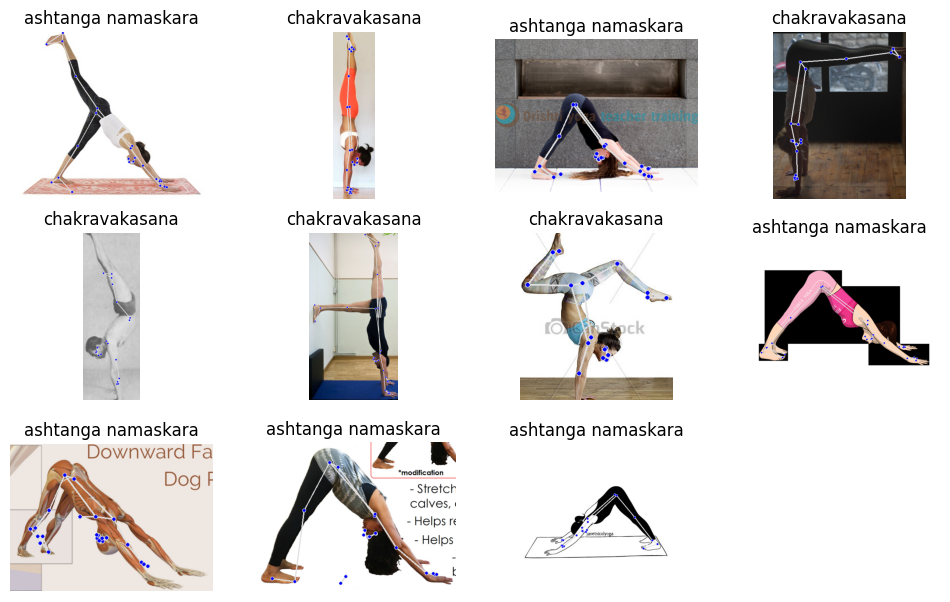

In [26]:
import cv2
import matplotlib.pyplot as plt
import os
import mediapipe as mp
import torch

test_images_path = "/Users/jyothivishnuvardhankolla/Desktop/Yoga_pose_estimation/Pre_processed_data/test_images"

fig = plt.figure(figsize=(12, 10))
rows, cols = 4, 4
i = 0
class_names = [name for name in os.listdir(
        "/Users/jyothivishnuvardhankolla/Desktop/Yoga_pose_estimation/dataset") if os.path.isdir(os.path.join("/Users/jyothivishnuvardhankolla/Desktop/Yoga_pose_estimation/dataset", name))]

def load_model():
    model_path = "/Users/jyothivishnuvardhankolla/Desktop/Yoga_pose_estimation/Models/model_ANNModel.pth"
    loaded_model = ComplexModel(99, 128, 107)
    loaded_model.load_state_dict(torch.load(model_path))
    return loaded_model.eval()

def get_data_point(key_points):
    final_datapoint = []
    for idx, landmark in enumerate(key_points.landmark):
        x, y, z = landmark.x, landmark.y, landmark.z
        final_datapoint.append(x)
        final_datapoint.append(y)
        final_datapoint.append(z)

    final_tensor = torch.tensor(final_datapoint, dtype=torch.float)
    return final_tensor

loaded_model = load_model()
pose = mp.solutions.pose.Pose(static_image_mode=True)
mp_drawing = mp.solutions.drawing_utils
i = 0
for file in os.listdir(test_images_path):
    img_path = os.path.join(test_images_path, file)
    image = cv2.imread(img_path)
    if image is not None:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        key_points = pose.process(image_rgb)
        if key_points.pose_landmarks is not None:
            key_points_tensor = get_data_point(key_points.pose_landmarks)
            prediction = loaded_model(key_points_tensor.unsqueeze(0))
            _, class_ = prediction.max(1)

            annotated_image = image_rgb.copy()
            mp_drawing.draw_landmarks(annotated_image, key_points.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS)
            fig.add_subplot(rows, cols, i + 1)
            plt.imshow(annotated_image)
            plt.title(class_names[class_])
            plt.axis('off')
            i += 1
            

pose.close()



In [ ]:
if image is not None:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        result = pose.process(image_rgb)
        print(result)
        key_points = result.pose_landmarks
        print(key_points)
        key_point_tensor = get_data_point(key_points)
        loaded_model = load_model()
        prediction = loaded_model(key_point_tensor.unsqueeze(0))
        _, class_ = prediction.max(1)
        print(class_)
        print(class_names[int(class_)])
        # Draw keypoints and connections on the image
        annotated_image = image_rgb.copy()
        mp_drawing.draw_landmarks(annotated_image, result.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS)
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(annotated_image)
        plt.axis('off')
        i += 1
        #break